#Deep Learning Assignment Major Project

by

Param Biyani (2019A7PS0059G)

Tanmay Devale (2019A7PS0066G)

Vishal Bharambe (2019A7PS0160G)

Link to all our models: https://drive.google.com/drive/folders/1dG1PzWAaukCi9Fiy_ZVOM-DsgpkHMwav?usp=sharing

### Setup

In [ ]:
!pip install hiddenlayer

In [ ]:
from IPython.display import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from prettytable import PrettyTable
from tqdm import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import PIL
from PIL import Image
import random

import hiddenlayer as hl
import cv2

import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns


In [ ]:
batch_size = 64
PIL2Tensor = transforms.Compose([transforms.ToTensor()])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_loader = torch.utils.data.DataLoader(datasets.STL10('/content/drive/MyDrive/DL/MajorProject', split = 'train', transform = PIL2Tensor),
                                           shuffle=True, batch_size = batch_size)

In [ ]:
test_loader = torch.utils.data.DataLoader(datasets.STL10('/content/drive/MyDrive/DL/MajorProject', split = 'test', transform = PIL2Tensor),
                                           shuffle=True, batch_size = batch_size)

In [ ]:
unlabeled_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(datasets.STL10('/content/drive/MyDrive/DL/MajorProject', split = 'unlabeled', 
                                                              transform = PIL2Tensor), range(20000, 40000)), shuffle=True, batch_size = batch_size)

### Task 1

Train a neural network (architecture details upto you) in a supervised manner on the training portion of the labeled part of STL-10.


For training the neural network we tried various architecture 30-40 epochs

1) ResNet 50 - accuracy was around 52%

2) ResNet 18 - accuracy was around 56%

3) VGG16     - accuracy was around 47%

4) ResNet 9  - accuracy was around 72%



In [ ]:
class ResNet9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 256), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 256,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(in_channels = 512,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.MaxPool2d(6), 
            nn.Flatten(), 
            nn.Dropout(0.2),
            )
        self.mlp = nn.Sequential(
            nn.Linear(512,10)
        )

        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        out = self.mlp(out)
        return out


We use Image Augmentation to diversify the small labeled dataset (5k).

The following augmentations have been used:

1) Random resized crop

2) Random horizontal flip with a probability of 50%

3) Random color jittering with a probability of 80%

4) Random grayscale with a probability of 20%

5) Gaussian Blur with a probability of 20%

6) Solarization with a probability of 10%

In [ ]:
class Augment:
    def __init__(self, prob):
        self.prob = prob
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(96, interpolation=Image.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                        saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=0.2),
            Solarization(p=0.1),
        ])

    def __call__(self, x):
        if random.random() > self.prob:
            return x
        x = self.transform(x)
        return x


class debuger(object):
    def __call__(self, img):
        print(type(img))
        return img

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(PIL.ImageFilter.GaussianBlur(sigma))
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return PIL.ImageOps.solarize(img)
        else:
            return img



We call a new version of the dataset with the Transformer attached Augmenting with 50% probabilty.

In [ ]:
Transformer = transforms.Compose([Augment(0.5), transforms.ToTensor()])

train_loader_a = torch.utils.data.DataLoader(datasets.STL10('/content/drive/MyDrive/DL/MajorProject', split = 'train', transform = Transformer),
                                           shuffle=True, batch_size = 64)
test_loader_a = torch.utils.data.DataLoader(datasets.STL10('/content/drive/MyDrive/DL/MajorProject', split = 'test', transform = Transformer),
                                           shuffle=True, batch_size = 64)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:853: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
def train(dataloader, epochs, model, optim, loss_f):

    model.train()

    for epoch in range(epochs):

        for batch_idx, (data, target) in enumerate(dataloader):

            data, target = data.to(device), target.to(device)
            optim.zero_grad()
            output = model(data)
            loss = loss_f(output, target)
            loss.backward()
            optim.step()
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
                
        test(test_loader_a, model)
                
def test(dataloader, model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader:

        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader.dataset),
        accuracy))
    
    return accuracy

In [ ]:
# We name the model for Task 1 model1
model1 = ResNet9().to(device)
optim1 = torch.optim.Adam(model1.parameters(), lr = 0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
train(train_loader_a, 30, model1, optim1, loss)

In [ ]:
torch.save(model1, '/content/drive/MyDrive/DL/MajorProject/model_step1_70_a.pth')

To demostrate our model, we load the model which we trained previously.

In [ ]:
model1 = torch.load('/content/drive/MyDrive/DL/MajorProject/model_step1_70_a.pth',map_location=device)

In [ ]:
model1.eval()

Testing accuracy of 74% was achieved. We tried various augmentation, and numerous models, the best one is hown here.

In [ ]:
test(test_loader, model1)


Test set: Average loss: -7.8136, Accuracy: 5917/8000 (74%)



73.9625

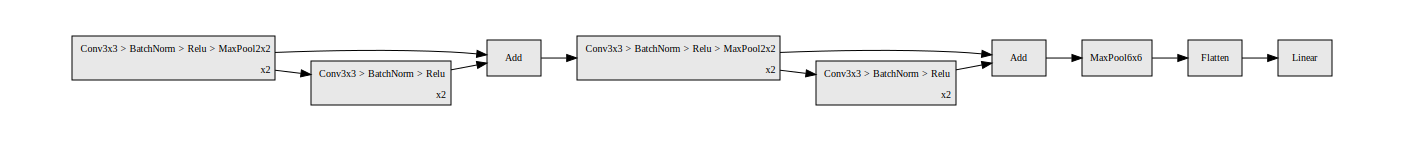

In [ ]:
transforms_hl_ResNet9 = [hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    hl.transforms.Fold("ConvBnRelu > MaxPool", "ConvBnReluMaxPool"),
    hl.transforms.FoldDuplicates(),
]
hl.build_graph(model1 ,torch.zeros([64,3,96,96]).to(device), transforms = transforms_hl_ResNet9)

### Task 2

Use the Barlow Twins method to train a neural network on a subset of the unlabelled part of STL-10 to produce appropriate embeddings. For this you should read through [2]. While you don’t need to understand the complete paper, it will give you helpful context and it also has PyTorch style pseudocode which may help you write your own implementation. The size of the subset along with the particular architecture of the neural network is upto you.

Due to constrains of computing power and time we ran for 30-40 epochs to obtain these results. We might have obtained better results with a more powerful system.

#### Augmentation Transformer Augment2 returns two augmented version of a single input image.

References: Official Paper code (https://github.com/facebookresearch/barlowtwins)


In [ ]:
class Augment2:
    def __init__(self):
        self.transform1 = transforms.Compose([
            transforms.RandomResizedCrop(96, interpolation=Image.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                        saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=0.2),
            Solarization(p=0.1),
            transforms.ToTensor()
        ])
        self.transform2 = transforms.Compose([
            transforms.RandomResizedCrop(96, interpolation=Image.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.3, contrast=0.3,
                                        saturation=0.3, hue=0.2)],
                p=0.7
            ),
            transforms.RandomGrayscale(p=0.3),
            GaussianBlur(p=0.3),
            Solarization(p=0.15),
            transforms.ToTensor()
        ])

    def __call__(self, x):
        y1 = self.transform1(x)
        y2 = self.transform2(x)
        ret = (y1, y2)
        return ret

class GaussianBlur(object): 
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(PIL.ImageFilter.GaussianBlur(sigma))
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return PIL.ImageOps.solarize(img)
        else:
            return img



In [ ]:
unlabeled_loader_a = torch.utils.data.DataLoader(torch.utils.data.Subset(datasets.STL10('/content/drive/MyDrive/DL/Major Project', split = 'unlabeled', 
                                                                                        transform = Augment2()), range(0, 20000)),shuffle=True, batch_size = batch_size)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:853: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


#### Barlow Twins Implementation

In [ ]:
class ResNet9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 256), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 256,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(in_channels = 512,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.MaxPool2d(6), 
            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(512,512)
            )

        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [ ]:
 class BarlowTwins(nn.Module):
  def __init__(self):
    
    super(BarlowTwins, self).__init__()
    self.backbone = ResNet9()

    self.projector = nn.Sequential(
        nn.Linear(512, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Linear(2048, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Linear(2048, 4096),
    )

    self.batch_norm = nn.BatchNorm1d(4096, affine = False)
  def forward(self,y_a, y_b, batch_size, lambd):
    z_a = self.projector(self.backbone(y_a))
    z_b = self.projector(self.backbone(y_b))

    z_a_norm = self.batch_norm(z_a)
    z_b_norm = self.batch_norm(z_b)

    c = (z_a_norm.T @ z_b_norm) / batch_size

    dia = torch.diagonal(c).add_(-1).pow_(2).sum()
    not_dia = (c.flatten()[:-1].view(c.shape[0] - 1, c.shape[0] + 1)[:, 1:].flatten()).pow_(2).sum()
    loss = dia + lambd*not_dia
    return z_a, z_b, loss



In [ ]:
def train(dataloader, epochs, model, optim, batch_size, lambd):

    model.train()

    for epoch in range(epochs):
      for batch_idx, ((y_a,y_b), _) in enumerate(dataloader):
        y_a = y_a.to(device)
        y_b = y_b.to(device)
        _, _, loss = model(y_a,y_b,batch_size, lambd)
        loss.backward()
        optim.step()
        targets, outputs = gen_features(model, train_loader)
        tsne_plot(args.save_dir, targets, outputs, epoch)
        model.train()
      print(loss.item())

In [ ]:
model2 = BarlowTwins().to(device)
optim2 = torch.optim.Adam(model2.parameters(), lr = 0.0001)

In [ ]:
train(unlabeled_loader_a, 20, model = model2, optim = optim2, batch_size = batch_size, lambd = 0.005)

generating t-SNE plot for epoch0
2958.92626953125
generating t-SNE plot for epoch1
2786.896484375
generating t-SNE plot for epoch2
2908.80419921875
generating t-SNE plot for epoch3
2832.8330078125
generating t-SNE plot for epoch4
2729.9716796875
generating t-SNE plot for epoch5
2531.319580078125
generating t-SNE plot for epoch6
2560.3056640625
generating t-SNE plot for epoch7
2425.85595703125
generating t-SNE plot for epoch8
2541.9765625
generating t-SNE plot for epoch9
2640.35400390625
generating t-SNE plot for epoch10
2342.57666015625
generating t-SNE plot for epoch11
2560.964599609375
generating t-SNE plot for epoch12
2503.989501953125
generating t-SNE plot for epoch13
2372.67041015625
generating t-SNE plot for epoch14
2336.45947265625
generating t-SNE plot for epoch15
2431.9404296875
generating t-SNE plot for epoch16
2398.50537109375
generating t-SNE plot for epoch17
2216.6396484375
generating t-SNE plot for epoch18
2311.7431640625
generating t-SNE plot for epoch19
2149.05102539062

In [ ]:
train(unlabeled_loader_a, 5, model = model2, optim = optim2, batch_size = batch_size, lambd = 0.005)

generating t-SNE plot for epoch0
2177.07080078125
generating t-SNE plot for epoch1
2216.71484375
generating t-SNE plot for epoch2
2129.771728515625
generating t-SNE plot for epoch3
2258.6708984375
generating t-SNE plot for epoch4
2238.87646484375


In [ ]:
torch.save(model1, '/content/drive/MyDrive/DL/MajorProject/BT.pth')

In [ ]:
model2 = torch.load('/content/drive/MyDrive/DL/MajorProject/BT.pth', map_location=device)

In [ ]:
model2.eval()

BarlowTwins(
  (backbone): ResNet9(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (res1): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3)

### Task 3
Visualise how your representation space evolves during training in the self-supervised
approach from Step 2. You are free to do this in any way you feel appropriate. The
goal should be to convey the changes to the representation space in an intuitive
way. (Hint: t-SNE).

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

def gen_features(model, dataloader):
    model.eval()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(train_loader):
            inputs , target = inputs.to(device) , targets.to(device)
            targets_np = targets.data.cpu().numpy()

            outputs,_,_ = model(inputs,inputs, 64, 0.005)
            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx+1) % 10 == 0) or (idx+1 == len(train_loader)):
                print(idx+1, '/', len(train_loader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

def tsne_plot(targets, outputs, epoch):
    print('generating t-SNE plot for epoch{}'.format(epoch))
    
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.color_palette("hls", 10),
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

    plt.savefig('/content/drive/MyDrive/3-1/CS F425 Deep Learning/Major Project/tsne{}.png'.format(epoch), bbox_inches='tight')

# targets, outputs = gen_features()
# tsne_plot(args.save_dir, targets, outputs)

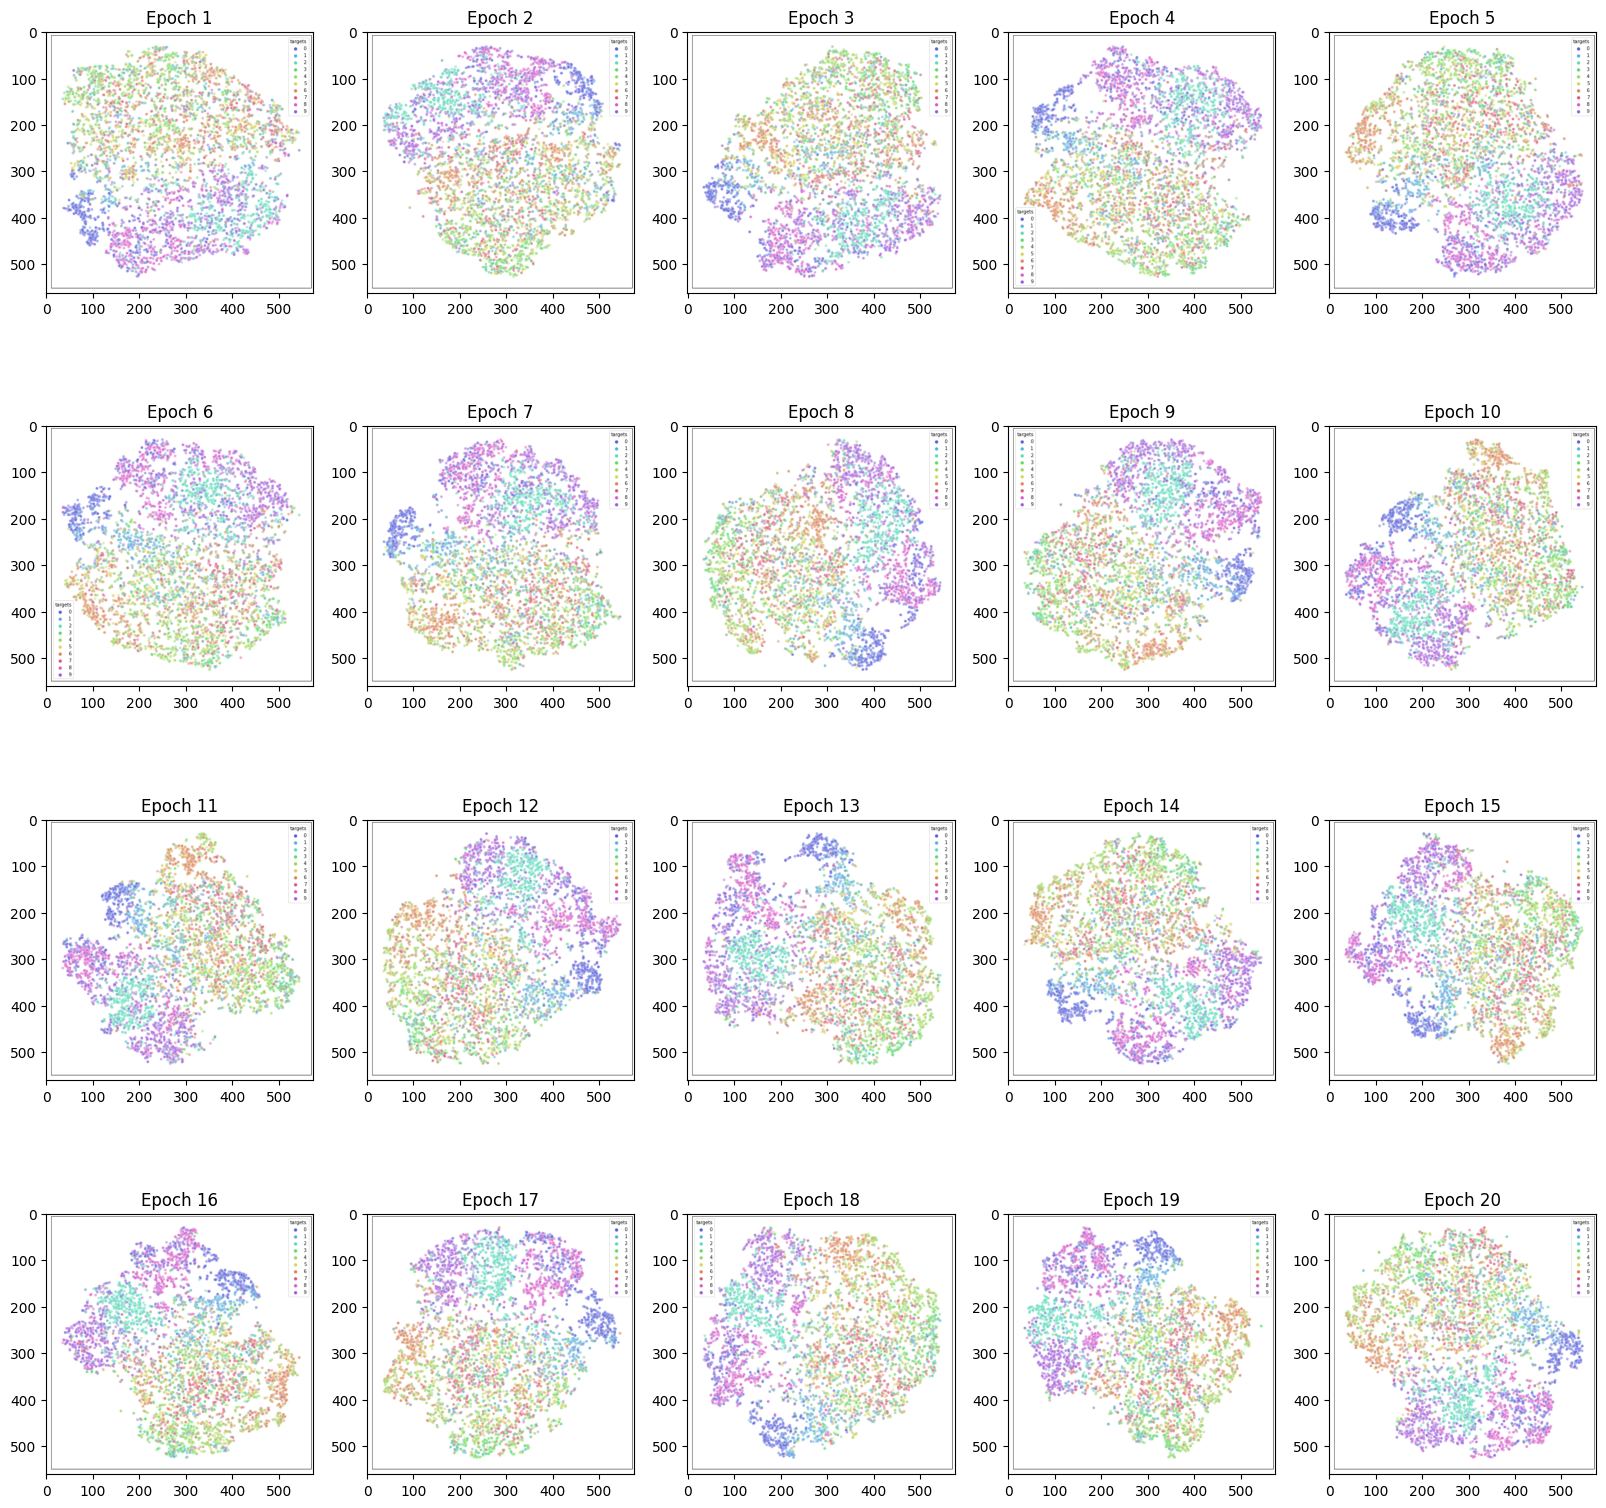

In [ ]:
fig = plt.figure(figsize=(20,20),dpi =100)
for i in range(20):
  img = cv2.imread('/content/drive/MyDrive/DL/MajorProject/t-SNE images/tsne{}.png'.format(i))
  fig.add_subplot(4, 5, i+1)
  plt.imshow(img)
  plt.title("Epoch {}".format(i+1))
  

In [ ]:
img.shape

(561, 575, 4)

### Task 4
Learn a linear classifier on top of the embedding network learnt in Step 2(whose
weights should be frozen) using the training portion of the labeled part of STL-10

In [ ]:
class BarlowTwinsFC(nn.Module):
  def __init__(self):
    
    super(BarlowTwinsFC, self).__init__()
    
    self.backbone = model2.backbone
    self.backbone.requires_grad_ = False

    self.projector = nn.Sequential(
        nn.Linear(2048, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )

  def forward(self,data):
    y_pred = self.projector(self.backbone(data))
    return F.log_softmax(y_pred)

In [ ]:
model4 = BarlowTwinsFC().to(device)
optim4 = torch.optim.Adam(model4.parameters(), lr = 0.001)
loss4 = torch.nn.CrossEntropyLoss()

The training and testing both were conducted on augmented train and test data.

In [ ]:
train(train_loader_a, 10, model4, optim4, loss4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/5000 (0%)]	Loss: 2.357248
Train Epoch: 0 [3200/5000 (63%)]	Loss: 1.310172

Test set: Average loss: 1.9616, Accuracy: 2812/8000 (35%)

Train Epoch: 1 [0/5000 (0%)]	Loss: 2.159253
Train Epoch: 1 [3200/5000 (63%)]	Loss: 1.928406

Test set: Average loss: 1.9309, Accuracy: 2005/8000 (25%)

Train Epoch: 2 [0/5000 (0%)]	Loss: 1.899001
Train Epoch: 2 [3200/5000 (63%)]	Loss: 1.498900

Test set: Average loss: 1.6569, Accuracy: 3139/8000 (39%)

Train Epoch: 3 [0/5000 (0%)]	Loss: 1.406862
Train Epoch: 3 [3200/5000 (63%)]	Loss: 1.157265

Test set: Average loss: 1.3009, Accuracy: 4105/8000 (51%)

Train Epoch: 4 [0/5000 (0%)]	Loss: 1.202767
Train Epoch: 4 [3200/5000 (63%)]	Loss: 1.377410

Test set: Average loss: 1.3083, Accuracy: 4247/8000 (53%)

Train Epoch: 5 [0/5000 (0%)]	Loss: 1.452359
Train Epoch: 5 [3200/5000 (63%)]	Loss: 1.226780

Test set: Average loss: 1.3061, Accuracy: 4130/8000 (52%)

Train Epoch: 6 [0/5000 (0%)]	Loss: 1.099438
Train Epoch: 6 [3200/5000 (63%)]	Loss: 1.121

In [ ]:
train(train_loader_a, 10, model4, optim4, loss4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/5000 (0%)]	Loss: 1.910806
Train Epoch: 0 [3200/5000 (63%)]	Loss: 1.223354

Test set: Average loss: 1.0591, Accuracy: 4951/8000 (62%)

Train Epoch: 1 [0/5000 (0%)]	Loss: 0.765040
Train Epoch: 1 [3200/5000 (63%)]	Loss: 1.180538

Test set: Average loss: 1.1350, Accuracy: 4810/8000 (60%)

Train Epoch: 2 [0/5000 (0%)]	Loss: 0.887435
Train Epoch: 2 [3200/5000 (63%)]	Loss: 1.103874

Test set: Average loss: 1.3896, Accuracy: 4154/8000 (52%)

Train Epoch: 3 [0/5000 (0%)]	Loss: 1.164434
Train Epoch: 3 [3200/5000 (63%)]	Loss: 0.752033

Test set: Average loss: 1.1191, Accuracy: 4823/8000 (60%)

Train Epoch: 4 [0/5000 (0%)]	Loss: 1.021563
Train Epoch: 4 [3200/5000 (63%)]	Loss: 0.757599

Test set: Average loss: 1.3009, Accuracy: 4436/8000 (55%)

Train Epoch: 5 [0/5000 (0%)]	Loss: 0.905978
Train Epoch: 5 [3200/5000 (63%)]	Loss: 0.834462

Test set: Average loss: 1.5010, Accuracy: 4032/8000 (50%)

Train Epoch: 6 [0/5000 (0%)]	Loss: 1.330210
Train Epoch: 6 [3200/5000 (63%)]	Loss: 0.754

Testing on non-augmented test data.

In [ ]:
test(test_loader, model4)
#Recieved an accuracy of 75.8%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.7618, Accuracy: 6066/8000 (76%)



75.825

In [ ]:
torch.save(model4, '/content/drive/MyDrive/DL/MajorProject/BT+FC_76.pth')

In [ ]:
model4 = torch.load('/content/drive/MyDrive/DL/MajorProject/BT+FC_76.pth', map_location=device)

### Task 5
Having trained a fully supervised and a fully self-supervised model, consider a
case where your training data consists of some mix of unlabeled and labeled data
from STL-10. Formulate a way to combine both the supervised and self-supervised
training procedures to make use of such a dataset to train a classifier.

**The strategy** is to use the model1 trained in Task 1 to label unlabelled data, select those points with a minimum confidence, and train another model on that larger set.

In [ ]:
model1.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


We first tried to use the same ResNet9 architecture for the new model, but found that it's accuracy saturated too quickly. So we shifted to a larger ResNet12 architecture.

In [ ]:
class ResNet12(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 32), 
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 64), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64,out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 64), 
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128,out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128), 
            nn.ReLU(inplace=True),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 256), 
            nn.ReLU(inplace=True),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels = 256,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(in_channels = 512,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512,out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512), 
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(6), 
            nn.Flatten(), 
            nn.Dropout(0.2),
            )
        self.mlp = nn.Sequential(
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,64),
            nn.ReLU(),
            nn.Linear(64,10),
        )

        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        out = self.mlp(out)
        return out

Predicting labels for the unlabeled data. We used a minimum confidence of 0.95 as a threshold. We were limited to only use 20k unlabeled data points at a time due to resource constraints.

In [ ]:
unlabeled_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(datasets.STL10('/content/drive/MyDrive/DL/MajorProject', split = 'unlabeled', 
                                                              transform = PIL2Tensor), range(5000, 25000)), shuffle=True, batch_size = batch_size)

In [ ]:
labels = []
images = []
for batch_idx, (data, target) in tqdm(enumerate(unlabeled_loader)):
  data, target = data.to(device), target.to(device)
  output = F.softmax(model1(data))
  output2 = torch.argmax(output, dim = -1)
  for i in range(len(output)):
    if(output[i][output2[i]]>=0.95):
      images.append(data[i])
      labels.append(output2[i])

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
313it [00:29, 10.73it/s]


In [ ]:
len(labels)

5442

A simple dataloader for our new dataset.

In [ ]:
class newLabeled_train(torch.utils.data.Dataset):

  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    _x = self.X[index]
    _y = self.Y[index]

    return _x, _y

In [ ]:
newlabeled_train = torch.utils.data.DataLoader(newLabeled_train(images, labels), batch_size=64, shuffle=True)

In [ ]:
del(unlabeled_loader)

In [ ]:
def train5(dataloader, epochs, model, optim, loss_f):

    model.train()

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(dataloader):

            data = data.to(device)
            target = target.to(device)
            # target = labels[batch_idx].to(device).clone().detach()
            optim.zero_grad()
            output = model(data)
            loss = loss_f(output, target)
            loss.backward()
            optim.step()
            if batch_idx % 100 == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} {100. * batch_idx / len(dataloader)}%)]\tLoss: {loss.item()}")
                losslist.append(loss.item())
        test5(test_loader, model)


def test5(dataloader, model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader:

        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader.dataset),
        accuracy))
    model.train()
    
    return accuracy

In [ ]:
# We name our model for Task 5 as model5.
model5 = ResNet12().to(device)
optim5 = torch.optim.Adam(model5.parameters(), lr = 0.001)
loss = torch.nn.CrossEntropyLoss()

Due to resource constraints we trained the same model multiple times, each time with a different data input. 

In [ ]:
losslist = []

In [ ]:
train5(train_loader, 4, model5, optim5, loss)

Train Epoch: 0 [0/5000 0.0%)]	Loss: 0.23724955320358276

Test set: Average loss: -5.9877, Accuracy: 5859/8000 (73%)

Train Epoch: 1 [0/5000 0.0%)]	Loss: 0.5590807199478149

Test set: Average loss: -6.4253, Accuracy: 5889/8000 (74%)

Train Epoch: 2 [0/5000 0.0%)]	Loss: 0.5015161037445068

Test set: Average loss: -7.7606, Accuracy: 5935/8000 (74%)

Train Epoch: 3 [0/5000 0.0%)]	Loss: 0.5491650104522705

Test set: Average loss: -7.0089, Accuracy: 5825/8000 (73%)



In [ ]:
torch.save(model5, '/content/drive/MyDrive/DL/MajorProject/model_big_step5_73.pth')

In [ ]:
model5 = torch.load('/content/drive/MyDrive/DL/MajorProject/model_big_step5_73.pth', map_location=device)

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1630: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


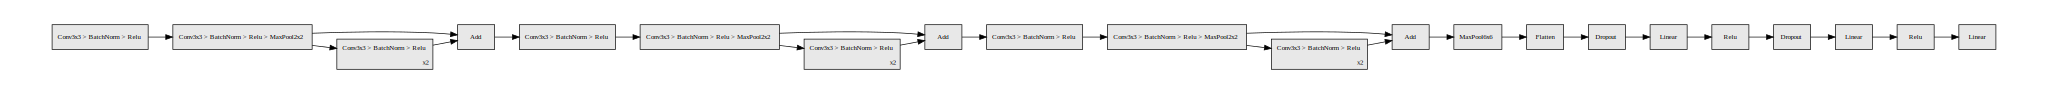

In [ ]:
transforms_hl_ResNet9 = [hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    hl.transforms.Fold("ConvBnRelu > MaxPool", "ConvBnReluMaxPool"),
    hl.transforms.FoldDuplicates(),
]
hl.build_graph(model5 ,torch.zeros([64,3,96,96]).to(device), transforms = transforms_hl_ResNet9)

### Task 6
Compare the performance of the classifiers from Steps 1, 4 and 5.

The following are our best versions for the models:



> Step 1: ResNet9. Accuracy 74%
>
> Step 4: ResNet9 for encoder. 2 hidden layered MLP for FC layer. Accuracy 75%
>
> Step 5: ResNet12 for predictor model, with Step 1's model as the labeling model. Accuracy 73%


We believe that with a larger barlow encoder, and more epochs trained on it, a better performance could have been delivered. Due to resource constraints, we chose a smaller model with less epochs trained on it. 

Due to training being divided on multiple platforms, and the training themselves being fragmented due to small data at a time to conserve RAM, no proper records were kept for loss evolution for each model. The respective models have been uploaded on cloud.

Possible ways to improve performance using the already available resources:


*   For step 5, augmented data could also be used to train FC network, to have a more diversified learning train set. This was not done as while using the Augmentation transform, we often ran out of GPU RAM causing us to use even smaller datasets at a time, slowing progress on each model significantly.







### Task 7
Study how the ratio of labeled and unlabeled data affects performance in
Step 5.

We found that the more the labeled unlabeled data we used the more the model halted at about 63-66% accuracy. As soon as we introduced the train data to train the predictor model, our accuracy went up to 74% as shown.

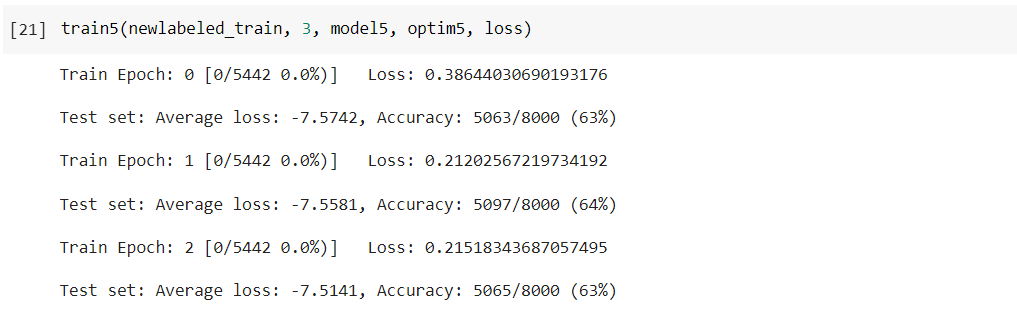


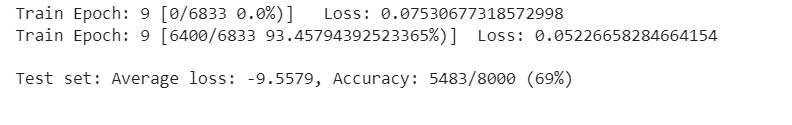

Above are the best training accuracies for using only labeled unlabeled data. 

We thank the TAs and Prof. Tithraj Dash for guiding us through our projects and solving our doubts.

### Extras

In one of the runs on Task 3 we recieved this clustering :). Did we accidentally cluster it on the training set? :p

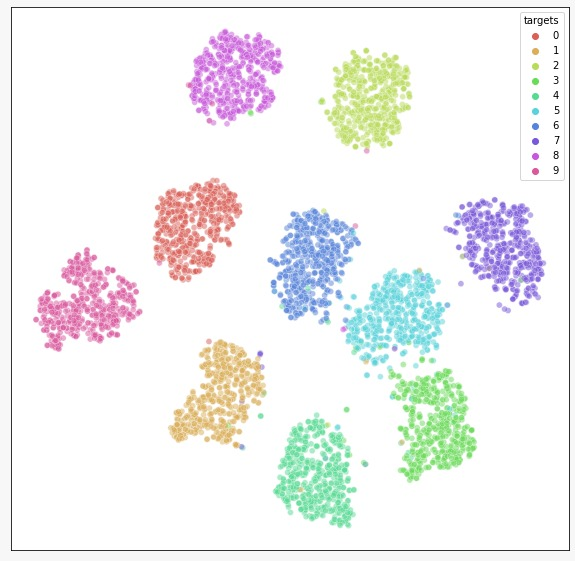